In [18]:
!pip install tensorflow scikit-learn seaborn

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [20]:
#initializing this for reproducability
np.random.seed(42)
tf.random.set_seed(42)

###Loading and reprocessing the data

In [21]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print(f"\nx_train.shape:{x_train.shape}")
print(f"y_train.shape:{y_train.shape}")
print(f"x_test.shape:{x_test.shape}")
print(f"y_test.shape:{y_test.shape}")

#Pixel normalisation
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print(f"\nNormalised pixel values: \nmin_pixel:{x_train.min()}\nmax_pixel:{x_train.max()}\nmean_pixel:{x_train.mean()}\nstd_pixel:{x_train.std()}")



x_train.shape:(60000, 28, 28)
y_train.shape:(60000,)
x_test.shape:(10000, 28, 28)
y_test.shape:(10000,)

Normalised pixel values: 
min_pixel:0.0
max_pixel:1.0
mean_pixel:0.28604018688201904
std_pixel:0.353023886680603


In [22]:
#Reshape
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [23]:
#assigining class labels here
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

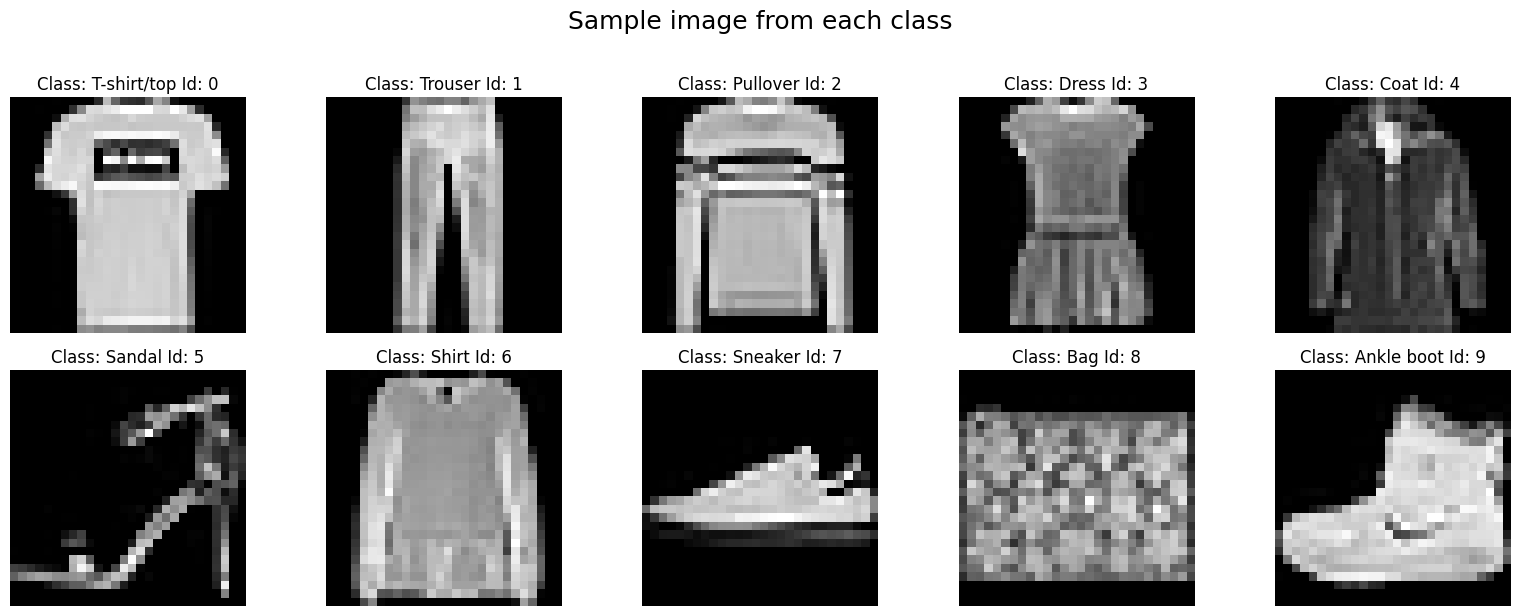

In [24]:
from numpy.random.mtrand import f
#displaying sample images from each class
unique_class = np.unique(y_train)

plt.figure(figsize=(16,6))
for i , id in enumerate(unique_class):
  idx = np.where(y_train == id)[0][0]
  img = x_train[idx]
  label = y_train[idx]

  plt.subplot(2,5,i+1)
  plt.imshow(img.squeeze(), cmap='gray')
  plt.title(f"Class: {class_labels[label]} Id: {label}")
  plt.axis('off')

plt.suptitle('Sample image from each class', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

In [25]:
#config
batch_size = 64
epochs = 15
learning_rate = 0.001


In [26]:
#data augmentation
data_aug = ImageDataGenerator(
    horizontal_flip=True, #randomly flips the images horizontally
    rotation_range=10, #rotates images upto 10 degrees
    width_shift_range=0.1, #randomly shifts images horizontally by 10%
    height_shift_range=0.1, #randomly shifts images vertically by 10%
    zoom_range=0.1 #randomly zooms images by 10%
)

####My Inference


*   I used fashion_mnist dataset for this assignment
*   Each image is 28*28 pixel grayscaled and there are 10 different classes of clothing in the dataset, which I have labelled for easy visualisation.
*   I have reshaped the dataset to have channel dimension, because CNN demands explicit channel specification
*   I have normalised the pixel values range to [0,1] to support better gradient flow, optimal execution of activation funcitons and to make each pixel contibute equally during the learning process
*   Next, I have implemented data augmentation using an inbuilt function 'ImageDataGenerator'. The main purpose is to create modified versions of the same input to prevent overfitting and generalize better.








###Train-test split and data training

In [27]:
#train-test split
x_train_2, x_val, y_train_2, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

#implementing data augmentation
data_aug.fit(x_train_2)
train_ds = data_aug.flow(x_train_2, y_train_2, batch_size=batch_size)
val_ds = data_aug.flow(x_val, y_val, batch_size=batch_size)

#creating test set from tf pipeline
test_df = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_df.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [28]:
#model implementation with 4 layers depth
def exec_cnn(input_shape=(28, 28, 1), num_classes=10):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),

        tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ], name="fashion_mnist_cnn_seq")

    return model

model = exec_cnn()
model.summary()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

model_history = model.fit(
    train_ds,
    epochs=15,
    validation_data=val_ds,
    callbacks=[early_stopping],
    verbose=1,
)

Model: "fashion_mnist_cnn_seq"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 459,146 (1.75 MB)

 Trainable params: 457,674 (1.75 MB)

 Non-trainable params: 1,472 (5.75 KB)

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


750/750 ━━━━━━━━━━━━━━━━━━━━ 33s 31ms/step - accuracy: 0.5793 - loss: 1.2660 - val_accuracy: 0.7898 - val_loss: 0.5610
Epoch 2/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.7642 - loss: 0.6193 - val_accuracy: 0.8036 - val_loss: 0.5001
Epoch 3/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.8047 - loss: 0.5266 - val_accuracy: 0.8471 - val_loss: 0.3994
Epoch 4/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.8206 - loss: 0.4814 - val_accuracy: 0.8427 - val_loss: 0.4068
Epoch 5/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.8292 - loss: 0.4549 - val_accuracy: 0.8533 - val_loss: 0.3818
Epoch 6/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.8432 - loss: 0.4249 - val_accuracy: 0.8628 - val_loss: 0.3675
Epoch 7/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.8487 - loss: 0.4069 - val_accuracy: 0.8755 - val_loss: 0.3326
Epoch 8/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.8535 - loss: 0.3946 - val_accurac

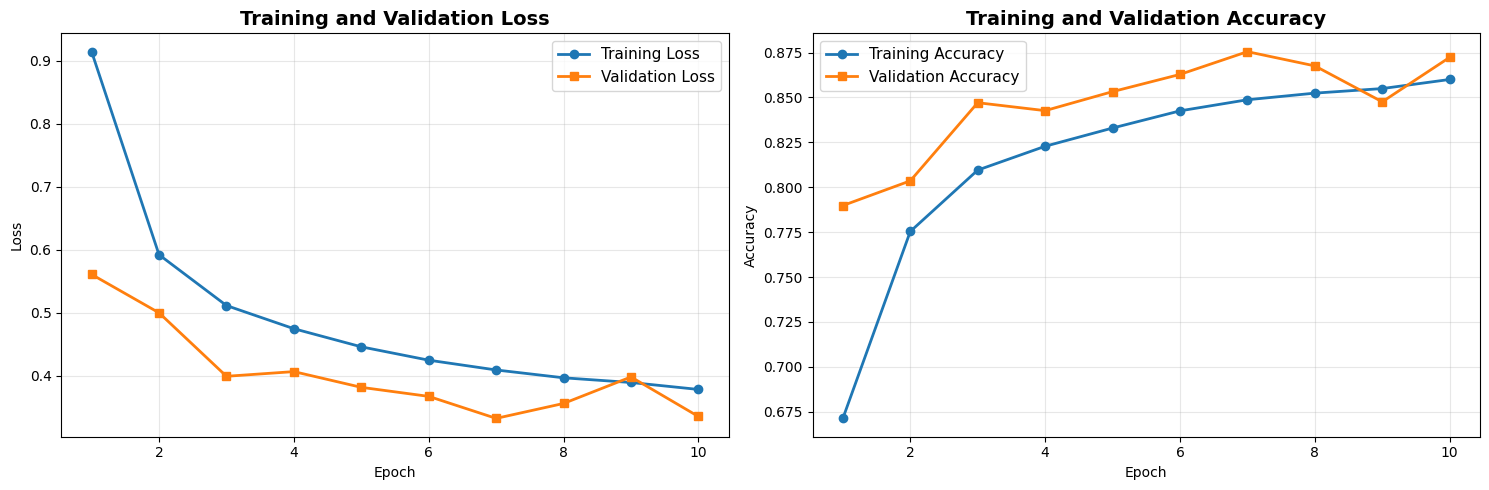

In [29]:
#training and validation plotted using matplotlib
def plot_training(history):
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))
  epoch_range = range(1, len(history.history['loss']) + 1)

  axes[0].plot(epoch_range, history.history['loss'], "o-", label='Training Loss', linewidth=2, markersize=6)
  axes[0].plot(epoch_range, history.history['val_loss'], "s-", label='Validation Loss', linewidth=2, markersize=6)
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Loss')
  axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight="bold")
  axes[0].legend(fontsize=11)
  axes[0].grid(True, alpha=0.3)

  axes[1].plot(epoch_range, history.history['accuracy'], "o-", label='Training Accuracy', linewidth=2, markersize=6)
  axes[1].plot(epoch_range, history.history['val_accuracy'], "s-", label='Validation Accuracy', linewidth=2, markersize=6)
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Accuracy')
  axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight="bold")
  axes[1].legend(fontsize=11)
  axes[1].grid(True, alpha=0.3)

  plt.tight_layout()
  plt.show()

plot_training(model_history)


###Model evaluation

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

Test Set Performance Metrics:
Accuracy : 0.8888
Precision: 0.8900
Recall   : 0.8888
F1-Score : 0.8884

Confusion Matrix:
[[887   0  12  18   1   1  66   0  15   0]
 [  1 982   1  11   1   0   2   0   2   0]
 [ 17   1 859   6  34   0  80   0   3   0]
 [ 26   5   8 880  25   0  44   0  12   0]
 [  0   0  73  33 735   0 152   0   6   1]
 [  0   0   0   0   0 988   0  10   0   2]
 [184   0  57  18  51   0 672   0  18   0]
 [  0   0   0   0   0  36   0 950   0  14]
 [  0   1   0   2   0   2   1   1 993   0]
 [  0   0   0   0   0  12   0  46   0 942]]


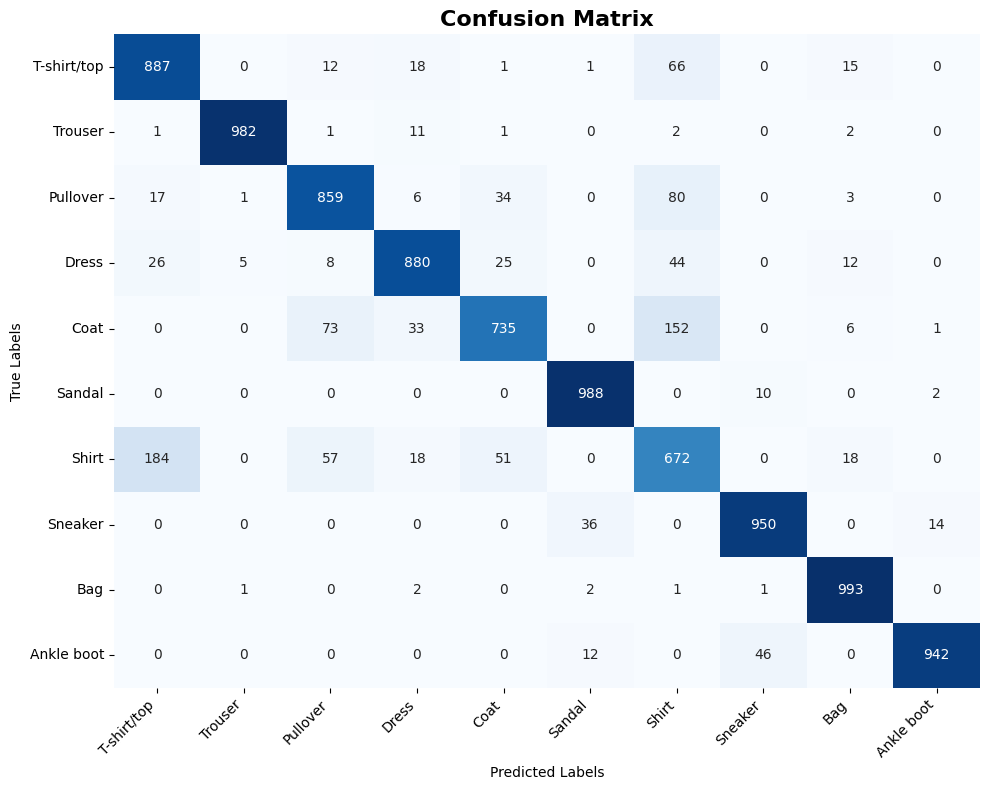


Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.80      0.89      0.84      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.85      0.86      0.85      1000
       Dress       0.91      0.88      0.89      1000
        Coat       0.87      0.73      0.80      1000
      Sandal       0.95      0.99      0.97      1000
       Shirt       0.66      0.67      0.67      1000
     Sneaker       0.94      0.95      0.95      1000
         Bag       0.95      0.99      0.97      1000
  Ankle boot       0.98      0.94      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [30]:
#model evaluation factors displayed
y_prob = model.predict(test_ds)
y_pred = np.argmax(y_prob, axis=1)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("\nTest Set Performance Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")

conf_matr = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matr)

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matr,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels,
    cbar=False,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Confusion Matrix", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_labels, zero_division=0))

####My Inference


*   I have split the training data into train and validation dataset and data augmentation is applied.
*   Implemented 4 layer CNN with regularisation strategies such as batch normalisation and dropout layers.
*   Implemented Relu activation to bring in non linearity
*   I have chosen Adam optimiser with a learning rate of 0.001
*   'sparse_categorical_crossentropy' penalises the confident wrong predictions heavily
*   The val accuracy is recorded as 0.8723 with a loss of 0.3356; Also the test accuracy is calculated as 0.8888
*   The model performs better on test data and it shows that the model generalises better. The small gap between validation and test accuracy shows minimal overfitting
*   The confusion matrix illustrates that the model does better with few classes like trouser, bag, sneaker, sandal but struggles with shirt, pullover due to overlapping features.












###Hyperparameter Tuning

In [31]:
#building a general model to accomodate multiple depths of layers to test hyper parameter tuning
def exec_cnn_temp(depth=4, input_shape=(28, 28, 1), num_classes=10):
    layers = [tf.keras.layers.Input(shape=input_shape)]

    layers.extend([
        tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
    ])

    layers.extend([
        tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
    ])

    if depth >= 3:
        layers.extend([
            tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.25),
        ])

    if depth == 4:
        layers.extend([
            tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.25),
        ])

    layers.extend([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ])

    model = tf.keras.Sequential(layers, name=f"fashion_mnist_cnn_{depth}layers")
    return model


In [32]:
#train the model with different combinations of hyperparameters
def train_model(depth, optimizer, learning_rate, epochs=15):
    model = exec_cnn_temp(depth=depth)

    if optimizer == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "SGD":
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(
        optimizer=opt,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0)
    start_time = time.time()
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks=[early_stopping],
        verbose=0
    )
    training_time = time.time() - start_time

    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    y_prob = model.predict(test_ds, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    print(f"\nModel depth: {depth} | learning rate: {learning_rate} | optimizer: {optimizer}")
    print(f"Val Acc: {history.history["val_accuracy"][-1]}")
    print(f"Val Loss: {history.history["val_loss"][-1]}")
    print(f"Test Acc: {test_acc}")
    print(f"Test Loss: {test_loss}")
    print(f"Time: {training_time}s")


In [33]:
# Experiment 1: learning_rate=0.001, depth=4, optimizer=SGD
print("\nEXPERIMENT 1: learning_rate=0.001, depth=4, optimizer=SGD")
train_model(4, "SGD", 0.001)


# Experiment 2: depth=4, optimizer=Adam, test with learning_rates=[0.0001, 0.1]
print("\nEXPERIMENT 2: depth=4, optimizer=Adam, learning_rates=[0.0001, 0.1]")
for lr in [0.0001, 0.1]:
  train_model(4, "Adam", lr)


# Experiment 3: optimizer=Adam, learning_rate=0.001, test with depths=[2, 5]
print("\nEXPERIMENT 3: optimizer=Adam, learning_rate=0.001, depths=[2, 5]")
for depth in [2, 5]:
  train_model(depth, "Adam", 0.001)



EXPERIMENT 1: learning_rate=0.001, depth=4, optimizer=SGD

Model depth: 4 | learning rate: 0.001 | optimizer: SGD
Val Acc: 0.8178333044052124
Val Loss: 0.4635812044143677
Test Acc: 0.8367999792098999
Test Loss: 0.43505996465682983
Time: 331.3825612068176s

EXPERIMENT 2: depth=4, optimizer=Adam, learning_rates=[0.0001, 0.1]

Model depth: 4 | learning rate: 0.0001 | optimizer: Adam
Val Acc: 0.8541666865348816
Val Loss: 0.3861554265022278
Test Acc: 0.8517000079154968
Test Loss: 0.3854525685310364
Time: 343.3370678424835s

Model depth: 4 | learning rate: 0.1 | optimizer: Adam
Val Acc: 0.7229999899864197
Val Loss: 1.2461118698120117
Test Acc: 0.7263000011444092
Test Loss: 2.7835159301757812
Time: 113.99535489082336s

EXPERIMENT 3: optimizer=Adam, learning_rate=0.001, depths=[2, 5]

Model depth: 2 | learning rate: 0.001 | optimizer: Adam
Val Acc: 0.8525833487510681
Val Loss: 0.38359522819519043
Test Acc: 0.8460000157356262
Test Loss: 0.395467609167099
Time: 229.62140083312988s

Model depth:

####My Inference


*   I have executed the hyperparameter tuning and analysed its impact.

*   EXPERIMENT 1 - learning_rate=0.001, depth=4, optimizer=SGD
    *   SGD performed significantly worse compared to Adam optimiser, with a learning rate of 0.001
    *   Val_acc(0.8178)is approximately 5% lesser here; the test accuracy being 0.83, indcates a slight degree of overfitting here,
    *   **Takeaway** - Adam optimiser works better with learning rate 0.001 in a 4 layer CNN
  
*   EXPERIMENT 2 - depth=4, optimizer=Adam, learning_rates=[0.0001, 0.1]
    *   First the learning rate was decreased to 0.0001, and a test accuracy of 0.8517 is recorded
    *   Here, the model is more stable but the weights are updates slowly and demands more computation.  
    *   Early stopping was not triggered in this case, which hints the chance of underfitting.
    *   Next, I increased the learning rate unsually higher to 0.1, and noticed a severe drop in performance (test accuracy = 0.7263).
    *   We observe an unstable training due to high loss of around 1.246
    *   **Takeaway**: 0.001 is the optimal leraning rate which helps to converge better with high accuracy

*   EXPERIMENT 3 - optimizer=Adam, learning_rate=0.001, depths=[2, 5]
    *   I reduced the depth to 2 layers; the model's validation accuracy is 0.8525, with a validation loss of 0.3835
    *   The test accuracy being 0.846 indicates that the model generalises quite well
    *   Next, I increased the depth to 5 layers, during which the model took the longest time to train.
    *   The test accuracy is 0.87 which is still lower than the 4 layer model. It shows that making the model complex doesn't necessarily improve the overall performance.












###Transfer learning - Bonus

In [34]:
#implementing resnet
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

kernel_size = 3

def construct_res(x, filters, stride=1, conv_skip=False, name=None):
    skip = x

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', name=name+'_conv1')(x)
    x = layers.BatchNormalization(name=name+'_bn1')(x)
    x = layers.Activation('relu', name=name + '_relu1')(x)

    x = layers.Conv2D(filters, 3, padding='same', name=name+'_conv2')(x)
    x = layers.BatchNormalization(name=name+'_bn2')(x)

    if conv_skip:
        skip = layers.Conv2D(filters, 1, strides=stride, padding='same', name=name + '_skip_conv')(skip)
        skip = layers.BatchNormalization(name=name + '_skip_bn')(skip)

    x = layers.Add(name=name + '_add')([x, skip])
    x = layers.Activation('relu', name=name + '_relu2')(x)

    return x

In [35]:
def train_resnet(input_shape=(28, 28, 1), num_classes=10, num_blocks=3):
    inputs = layers.Input(shape=input_shape, name='input')

    x = layers.Conv2D(32, 3, strides=1, padding='same', name='init_conv')(inputs)
    x = layers.BatchNormalization(name='init_bn')(x)
    x = layers.Activation('relu', name='init_relu')(x)

    x = construct_res(x, 64, conv_skip=True, name='stage1_block1')
    for i in range(1, num_blocks):
        x = construct_res(x, 64, name=f'stage1_block{i+1}')

    x = construct_res(x, 128, stride=2, conv_skip=True, name='stage2_block1')
    for i in range(1, num_blocks):
        x = construct_res(x, 128, name=f'stage2_block{i+1}')

    x = construct_res(x, 256, stride=2, conv_skip=True, name='stage3_block1')
    for i in range(1, num_blocks):
        x = construct_res(x, 256, name=f'stage3_block{i+1}')

    x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = layers.Dense(128, activation='relu', name='dense_1')(x)
    x = layers.BatchNormalization(name='dense_bn')(x)
    x = layers.Dropout(0.5, name='dropout')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='output')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name='ResNet_fashion_mnist')
    return model


In [36]:
resnet = train_resnet(input_shape=(28, 28, 1), num_classes=10, num_blocks=3)
resnet.summary()

resnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

resnet_history = resnet.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Model: "ResNet_fashion_mnist"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 28, 28, 1) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ init_conv (Conv2D)  │ (None, 28, 28,    │        320 │ input[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ init_bn             │ (None, 28, 28,    │        128 │ init_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ init_relu           │ (None, 28, 28,    │          0 │ init_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_conv1 │ (None, 28, 28,    │     18,496 │ init_relu[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_bn1   │ (None, 28, 28,    │        256 │ stage1_block1_co… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_relu1 │ (None, 28, 28,    │          0 │ stage1_block1_bn… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_conv2 │ (None, 28, 28,    │     36,928 │ stage1_block1_re… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_skip… │ (None, 28, 28,    │      2,112 │ init_relu[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_bn2   │ (None, 28, 28,    │        256 │ stage1_block1_co… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_skip… │ (None, 28, 28,    │        256 │ stage1_block1_sk… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_add   │ (None, 28, 28,    │          0 │ stage1_block1_bn… │
│ (Add)               │ 64)               │            │ stage1_block1_sk… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_relu2 │ (None, 28, 28,    │          0 │ stage1_block1_ad… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block2_conv1 │ (None, 28, 28,    │     36,928 │ stage1_block1_re… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block2_bn1   │ (None, 28, 28,    │        256 │ stage1_block2_co… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block2_relu1 │ (None, 28, 28,    │          0 │ stage1_block2_bn… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block2_conv2 │ (None, 28, 28,    │     36,928 │ stage1_block2_re… │
│ (Conv2D)            │ 64)               │            │                 

 Total params: 4,351,626 (16.60 MB)

 Trainable params: 4,345,034 (16.57 MB)

 Non-trainable params: 6,592 (25.75 KB)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 102s 95ms/step - accuracy: 0.6583 - loss: 0.9845 - val_accuracy: 0.7792 - val_loss: 0.6024 - learning_rate: 0.0010
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 53s 70ms/step - accuracy: 0.8337 - loss: 0.4593 - val_accuracy: 0.7575 - val_loss: 0.6230 - learning_rate: 0.0010
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 56s 75ms/step - accuracy: 0.8647 - loss: 0.3756 - val_accuracy: 0.8593 - val_loss: 0.3833 - learning_rate: 0.0010
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 55s 74ms/step - accuracy: 0.8769 - loss: 0.3420 - val_accuracy: 0.8767 - val_loss: 0.3379 - learning_rate: 0.0010
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 59s 79ms/step - accuracy: 0.8886 - loss: 0.3155 - val_accuracy: 0.8648 - val_loss: 0.3922 - learning_rate: 0.0010
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 53s 71ms/step - accuracy: 0.8937 - loss: 0.2969 - val_accuracy: 0.8828 - val_loss: 0.3121 - learning_rate: 0.0010
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 81s 70ms/step - accuracy: 0.8976 - 

In [37]:
#evaluating the performance
test_loss, test_acc = resnet.evaluate(test_ds, verbose=1)

y_prob_res = resnet.predict(test_ds, verbose=0)
y_pred_res = np.argmax(y_prob_res, axis=1)

accuracy_resnet = accuracy_score(y_test, y_pred_res)
precision_resnet = precision_score(y_test, y_pred_res, average='weighted', zero_division=0)
recall_resnet = recall_score(y_test, y_pred_res, average='weighted', zero_division=0)
f1_resnet = f1_score(y_test, y_pred_res, average='weighted', zero_division=0)

print("\nResNet performance metrics:")
print(f"Accuracy : {accuracy_resnet:.4f}")
print(f"Precision: {precision_resnet:.4f}")
print(f"Recall   : {recall_resnet:.4f}")
print(f"F1-Score : {f1_resnet:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9353 - loss: 0.1881

ResNet performance metrics:
Accuracy : 0.9348
Precision: 0.9379
Recall   : 0.9348
F1-Score : 0.9355


####My Inference



*   Implemented transfer learning using resnet with three residual blocks per stage
*   This resnet implements skip connections, to avoid vanishing gradient problems. The model progressilvely downsamples the feautures in each stage
*   I have tried implementing adaptive learning rate using 'ReduceLROnPlateau' which increases its value when loss increased (at around epoch 10 and 14). It is necessary when the model struggles to find a better minima for convergence.
*   Resnet outperformed the 4 layered CNN with a test accuracy of 93.48%
*   Performance metrics being almost aligned with the accuracy indicates that there is no bias and the classification is stabilized.





